In [101]:
import sqlite3
import pandas as pd
import seaborn as sns
import math
from datetime import datetime
import plotly.express as px

In [102]:


# Connect to the SQLite database
conn = sqlite3.connect(r'caltrain_lat_long.db')

# Query the database and load the results into a pandas DataFrame
query = """
SELECT *
FROM train_locations
"""
df = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

In [103]:
df['stop_id'] = df['stop_id'].astype(int)

df['trip_id'] = df['trip_id'].astype(int)

In [104]:
def load_stops_data():
    stops_df = pd.read_csv('gtfs_data/stops.txt')
    stops_df = stops_df[stops_df['stop_id'].str.isnumeric()]
    return stops_df
def load_stop_times_data():
    stop_times_df = pd.read_csv('gtfs_data/stop_times.txt')
    return stop_times_df
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    r = 6371000  # Radius of Earth in meters
    return r * c

def has_train_arrived(train_lat, train_lon, stop_lat, stop_lon, threshold=100):
    distance = haversine(train_lat, train_lon, stop_lat, stop_lon)
    return distance <= threshold

In [105]:
stops_df = load_stops_data()
stop_times_df = load_stop_times_data()
stops_df['stop_id'] = stops_df['stop_id'].astype(int)

In [106]:
stops_df=stops_df.sort_values(by='stop_id')
stops_df.head()

,stop_id,stop_code,stop_name,stop_lat,stop_lon,zone_id,stop_desc,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding,platform_code
78,70011,70011,San Francisco Caltrain Station Northbound,37.776390,-122.394992,74634,NaN,NaN,0,san_francisco,NaN,1,NaN
79,70012,70012,San Francisco Caltrain Station Southbound,37.776348,-122.394935,74634,NaN,NaN,0,san_francisco,NaN,1,NaN
1,70021,70021,22nd Street Caltrain Station Northbound,37.757599,-122.391880,74634,NaN,NaN,0,22nd_street,NaN,2,NaN
2,70022,70022,22nd Street Caltrain Station Southbound,37.757583,-122.392404,74634,NaN,NaN,0,22nd_street,NaN,2,NaN
4,70031,70031,Bayshore Caltrain Station Northbound,37.709537,-122.401586,74634,NaN,NaN,0,bayshore,NaN,1,NaN


In [107]:
df2 = pd.merge(df,stop_times_df[['trip_id','stop_id','arrival_time']],on=['trip_id','stop_id'])
df2 = pd.merge(df2,stops_df[['stop_id','stop_name','parent_station','stop_lat','stop_lon']],on=['stop_id'])

In [108]:
# Apply the Haversine function to calculate distance for each row
df2['distance'] = df2.apply(lambda row: haversine(row['vehicle_lat'], row['vehicle_lon'], row['stop_lat'], row['stop_lon']), axis=1)


In [109]:
df2['timestamp']=pd.to_datetime(df2['timestamp'])
df2['date'] = df2['timestamp'].dt.date

In [110]:
def normalize_time(t):
    if int(t.split(":")[0]) >= 24:
        return "00" + t[2:]
    return t
# Normalize the arrival times


In [111]:
import pandas as pd
from datetime import datetime, time, timedelta


# Normalize the arrival times
def normalize_time(t):
    if int(t.split(":")[0]) >= 24:
        return "00" + t[2:]
    return t

df2['arrival_time'] = df2['arrival_time'].apply(normalize_time)

# Convert 'timestamp' to datetime
df2['timestamp'] = pd.to_datetime(df2['timestamp'])
df2['arrival_time'] = pd.to_datetime(df2['arrival_time'], format='%H:%M:%S').dt.time

# Function to calculate time difference in minutes
def calculate_time_difference(time1, time2):
    datetime1 = datetime.combine(datetime.today(), time1)
    datetime2 = datetime.combine(datetime.today(), time2)
    time_diff = datetime2 - datetime1
    return time_diff.total_seconds() / 60  # Return the difference in minutes

# Find the minimum distance for each combination of trip_id, stop_id, and date
min_distances = df2.groupby(['trip_id', 'stop_id', 'date'])['distance'].min().reset_index()

# Merge the minimum distances back to the original dataframe
merged_df = pd.merge(df2, min_distances, on=['trip_id', 'stop_id', 'date', 'distance'])

arrival_times = merged_df.groupby(['trip_id', 'stop_id', 'date']).first().reset_index()
arrival_times = arrival_times[['trip_id', 'stop_id', 'date', 'timestamp']]
arrival_times.rename(columns={'timestamp': 'actual_arrival_time'}, inplace=True)

# Merge with the original dataframe to get the scheduled arrival time
comparison_df = pd.merge(arrival_times, df2[['trip_id', 'stop_id', 'stop_name','parent_station','date', 'arrival_time']], on=['trip_id', 'stop_id', 'date'])

# Calculate the delay in minutes
comparison_df['delay_minutes'] = comparison_df.apply(
    lambda row: calculate_time_difference(row['actual_arrival_time'].time(), row['arrival_time']), axis=1
)
comparison_df.loc[comparison_df.delay_minutes > 500,'delay_minutes'] = 0.0
comparison_df.loc[comparison_df.delay_minutes < -100,'delay_minutes'] = 0.0
# Determine if the train is delayed
comparison_df['is_delayed'] = comparison_df['delay_minutes'] > 4

# Calculate the overall on-time performance based on unique trip counts
unique_trips = comparison_df.drop_duplicates(subset=['trip_id', 'stop_id', 'date'])
total_trips = len(unique_trips)
on_time_trips = len(unique_trips[unique_trips['is_delayed'] == False])
on_time_performance = (on_time_trips / total_trips) * 100

# print(comparison_df)
print(f"Total unique trips: {total_trips}")
print(f"On-time trips: {on_time_trips}")
print(f"On-time performance: {on_time_performance:.2f}%")


Total unique trips: 5049
On-time trips: 4724
On-time performance: 93.56%


In [112]:
df2['arrival_time']

0        15:52:00
1        15:50:00
2        16:03:00
3        17:05:00
4        15:52:00
           ...   
39443    11:02:00
39444    11:04:00
39445    11:05:00
39446    12:03:00
39447    12:12:00
Name: arrival_time, Length: 39448, dtype: object

In [113]:
df2.timestamp

0       2024-07-07 15:48:54
1       2024-07-07 15:48:54
2       2024-07-07 15:48:54
3       2024-07-07 15:48:54
4       2024-07-07 15:49:54
                ...        
39443   2024-07-13 11:04:04
39444   2024-07-13 11:04:04
39445   2024-07-13 11:04:04
39446   2024-07-13 11:04:04
39447   2024-07-13 11:04:04
Name: timestamp, Length: 39448, dtype: datetime64[ns]

<Axes: xlabel='delay_minutes', ylabel='Count'>

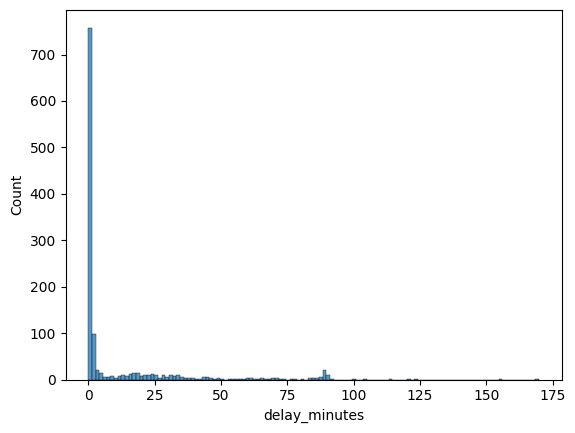

In [114]:
sns.histplot(data=unique_trips.loc[unique_trips.delay_minutes >=0],x='delay_minutes')

In [115]:
unique_trips.loc[(unique_trips.delay_minutes >4) & (unique_trips.delay_minutes <=15),'delay_severity'] = 'Minor'
unique_trips.loc[(unique_trips.delay_minutes >15),'delay_severity'] = 'Major'

C:\Users\Jonathan\AppData\Local\Temp\ipykernel_11140\3806708418.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [116]:
unique_trips['delay_severity'].unique()

array([nan, 'Major', 'Minor'], dtype=object)

<Axes: xlabel='delay_severity'>

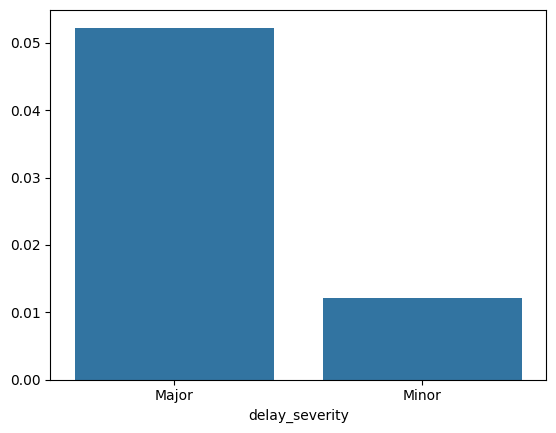

In [117]:
res = unique_trips.groupby('delay_severity').size() / total_trips
sns.barplot(res)

In [118]:
unique_trips['delay_severity'].fillna('On Time', inplace=True)

# Calculate percentage of delays by severity
delay_severity_counts = unique_trips['delay_severity'].value_counts(normalize=True) * 100
delay_severity_counts = delay_severity_counts.reset_index()
delay_severity_counts.columns = ['delay_severity', 'percentage']

C:\Users\Jonathan\AppData\Local\Temp\ipykernel_11140\2686362821.py:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\Jonathan\AppData\Local\Temp\ipykernel_11140\2686362821.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [119]:
# Create the bar plot using Plotly Express
fig = px.bar(delay_severity_counts, x='delay_severity', y='percentage', title="Percentage of Delayed Commutes by Severity",
             labels={'delay_severity': 'Delay Severity', 'percentage': 'Percentage'})
fig.show()

In [120]:
df3=unique_trips.copy()
df3.loc[df3.delay_minutes < 0,'delay_minutes'] =0

In [121]:
# day of week

In [122]:
# weekday vs weekend

In [123]:
def categorize_commute_time(timestamp):
    # Check if the day is a weekday (Monday=0, Sunday=6)
    if timestamp.weekday() >= 5:  # Saturday (5) and Sunday (6)
        return 'Weekend'
    
    morning_start = time(6, 0)
    morning_end = time(9, 0)
    evening_start = time(15, 30)
    evening_end = time(19, 30)
    
    commute_time = timestamp.time()
    
    if morning_start <= commute_time <= morning_end:
        return 'Morning'
    elif evening_start <= commute_time <= evening_end:
        return 'Evening'
    else:
        return 'Other'
unique_trips['commute_period'] =unique_trips['actual_arrival_time'].apply(categorize_commute_time)

# Filter for Morning and Evening commutes
filtered_trips = unique_trips[unique_trips['commute_period'].isin(['Morning', 'Evening'])]

# Calculate total trips for each commute period
total_commute_period_trips = filtered_trips.groupby('commute_period').size().reset_index(name='total_counts')

# Calculate counts of delays by commute period and severity
commute_delay_counts = filtered_trips.groupby(['commute_period', 'delay_severity']).size().reset_index(name='counts')

# Merge to get total counts for each commute period
commute_delay_counts = pd.merge(commute_delay_counts, total_commute_period_trips, on='commute_period')

# Calculate percentage of delays by commute period and severity
commute_delay_counts['percentage'] = (commute_delay_counts['counts'] / commute_delay_counts['total_counts']) * 100


C:\Users\Jonathan\AppData\Local\Temp\ipykernel_11140\3155030901.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [124]:
filtered_trips.groupby(['commute_period', 'delay_severity']).size().reset_index(name='counts')

,commute_period,delay_severity,counts
0,Evening,Major,69
1,Evening,Minor,21
2,Evening,On Time,1214
3,Morning,Major,40
4,Morning,Minor,9
5,Morning,On Time,764


In [125]:
commute_delay_counts

,commute_period,delay_severity,counts,total_counts,percentage
0,Evening,Major,69,1304,5.291411
1,Evening,Minor,21,1304,1.610429
2,Evening,On Time,1214,1304,93.098160
3,Morning,Major,40,813,4.920049
4,Morning,Minor,9,813,1.107011
5,Morning,On Time,764,813,93.972940


In [126]:
# morning, evening commutes 6-9a / 3:30-7:30p
unique_trips.sort_values(by='actual_arrival_time').tail(50)

,trip_id,stop_id,date,actual_arrival_time,stop_name,parent_station,arrival_time,delay_minutes,is_delayed,delay_severity,commute_period
19921,224,70232,2024-07-13,2024-07-13 09:55:54,Lawrence Caltrain Station Southbound,lawrence,09:55:00,-0.900000,False,On Time,Weekend
19993,225,70161,2024-07-13,2024-07-13 09:58:54,Menlo Park Caltrain Station Northbound,menlo_park,09:50:00,-8.900000,False,On Time,Weekend
19926,224,70242,2024-07-13,2024-07-13 10:01:54,Santa Clara Caltrain Station Southbound,santa_clara,10:01:00,-0.900000,False,On Time,Weekend
19987,225,70141,2024-07-13,2024-07-13 10:04:54,Redwood City Caltrain Station Northbound,redwood_city,09:56:00,-8.900000,False,On Time,Weekend
20102,228,70022,2024-07-13,2024-07-13 10:05:54,22nd Street Caltrain Station Southbound,22nd_street,10:03:00,-2.900000,False,On Time,Weekend
19932,224,70262,2024-07-13,2024-07-13 10:09:54,San Jose Diridon Caltrain Station Southbound,sj_diridon,10:10:00,0.100000,False,On Time,Weekend
20142,228,70032,2024-07-13,2024-07-13 10:09:54,Bayshore Caltrain Station Southbound,bayshore,10:08:00,-1.900000,False,On Time,Weekend
19982,225,70131,2024-07-13,2024-07-13 10:09:54,San Carlos Caltrain Station Northbound,san_carlos,10:01:00,-8.900000,False,On Time,Weekend
20263,229,70261,2024-07-13,2024-07-13 10:11:55,San Jose Diridon Caltrain Station Northbound,sj_diridon,10:12:00,0.083333,False,On Time,Weekend
19979,225,70121,2024-07-13,2024-07-13 10:12:55,Belmont Caltrain Station Northbound,belmont,10:04:00,-8.916667,False,On Time,Weekend


In [127]:
fig = px.histogram(unique_trips.loc[unique_trips.delay_minutes >=5],x='delay_minutes', color="commute_period",barmode='overlay')
fig.show()

In [128]:
unique_trips.date.unique()

array([datetime.date(2024, 7, 8), datetime.date(2024, 7, 10),
       datetime.date(2024, 7, 12), datetime.date(2024, 7, 9),
       datetime.date(2024, 7, 11), datetime.date(2024, 7, 13),
       datetime.date(2024, 7, 7)], dtype=object)

In [129]:
unique_trips.parent_station.unique()

array(['22nd_street', 'bayshore', 'south_sf', 'san_bruno', 'place_MLBR',
       'burlingame', 'san_mateo', 'hayward_park', 'hillsdale', 'belmont',
       'san_carlos', 'redwood_city', 'menlo_park', 'palo_alto',
       'california_ave', 'san_antonio', 'mountain_view', 'sunnyvale',
       'lawrence', 'santa_clara', 'sj_diridon', 'tamien', 'san_francisco',
       'college_park', 'broadway', 'capitol', 'blossom_hill',
       'morgan_hill', 'san_martin', 'gilroy'], dtype=object)

In [130]:
def clean_station_name(name):
    if name == 'place_MLBR':
        return 'Millbrae'
    name = name.replace('_', ' ')
    return name.title()
# Apply the cleaning function to parent_station names
unique_trips['parent_station'] = unique_trips['parent_station'].apply(clean_station_name)


C:\Users\Jonathan\AppData\Local\Temp\ipykernel_11140\832418268.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [131]:
(comparison_df['delay_minutes'] > 4) & (comparison_df['delay_minutes'] < 500)

0        False
1        False
2        False
3        False
4        False
         ...  
39443    False
39444    False
39445    False
39446    False
39447    False
Name: delay_minutes, Length: 39448, dtype: bool

In [132]:
import plotly.graph_objects as go
# Create a pivot table for the heatmap
# Create a pivot table for the heatmap
heatmap_data = unique_trips.pivot_table(index='trip_id', columns='stop_id', values='delay_minutes', aggfunc='mean', sort=False)
stop_id_to_parent_station = unique_trips[['stop_id', 'parent_station']].drop_duplicates().set_index('stop_id')['parent_station'].to_dict()

# Sort the columns of the pivot table explicitly
heatmap_data = heatmap_data[sorted(heatmap_data.columns)]
heatmap_data.columns = [stop_id_to_parent_station[stop_id] for stop_id in heatmap_data.columns]
heatmap_data.index=heatmap_data.index.astype(str)
# heatmap_data = heatmap_data.sort_index(axis=1)
# Create the heatmap using Plotly
fig_heatmap = go.Figure(data=go.Heatmap(
    z=heatmap_data.values,
    x=heatmap_data.columns,
    y=heatmap_data.index,
    colorscale='Viridis',

))

fig_heatmap.update_layout(
    title="Heatmap of Delays by Stop and Train Number",
    xaxis_title="Stop",
    yaxis_title="Train Number",
    height = 1000,
)

In [134]:
# scatter = go.Scatter(x=np.array(lon).flatten(),
#                      y=np.array(lat).flatten(),
#                      marker={'color': np.array(v).flatten(),
#                              'showscale': True},
#                      mode='markers')
# fig = go.FigureWidget(data=[scatter],
#                       layout={'xaxis': {'title': 'lon'},
#                               'yaxis': {'title': 'lat'}})
# fig

In [168]:
unique_trips

,trip_id,stop_id,date,actual_arrival_time,stop_name,parent_station,arrival_time,delay_minutes,is_delayed,delay_severity,commute_period
0,101,70021,2024-07-08,2024-07-08 05:55:19,22nd Street Caltrain Station Northbound,22Nd Street,05:55:00,0.00,False,On Time,Other
6,101,70021,2024-07-10,2024-07-10 05:59:41,22nd Street Caltrain Station Northbound,22Nd Street,05:55:00,0.00,False,On Time,Other
11,101,70021,2024-07-12,2024-07-12 05:57:58,22nd Street Caltrain Station Northbound,22Nd Street,05:55:00,0.00,False,On Time,Other
17,101,70031,2024-07-08,2024-07-08 05:49:03,Bayshore Caltrain Station Northbound,Bayshore,05:50:00,0.95,False,On Time,Other
23,101,70031,2024-07-10,2024-07-10 05:54:41,Bayshore Caltrain Station Northbound,Bayshore,05:50:00,0.00,False,On Time,Other
...,...,...,...,...,...,...,...,...,...,...,...
39408,712,70172,2024-07-11,2024-07-11 18:50:05,Palo Alto Caltrain Station Southbound,Palo Alto,18:47:00,0.00,False,On Time,Evening
39412,712,70172,2024-07-12,2024-07-12 18:47:41,Palo Alto Caltrain Station Southbound,Palo Alto,18:47:00,0.00,False,On Time,Evening
39420,712,70212,2024-07-10,2024-07-10 19:00:02,Mountain View Caltrain Station Southbound,Mountain View,18:55:00,0.00,False,On Time,Evening
39431,712,70212,2024-07-11,2024-07-11 19:01:06,Mountain View Caltrain Station Southbound,Mountain View,18:55:00,0.00,False,On Time,Evening


In [156]:
# Calculate percentage of delays by severity
daily_summary = unique_trips.groupby('date')['delay_severity'].value_counts(normalize=True).unstack() * 100

# # Reset index to have date as a column
daily_summary = daily_summary.reset_index()
# # Melt the DataFrame for Plotly
daily_summary_melted = daily_summary.melt(id_vars='date', value_vars=['Major',	'Minor','On Time'], var_name='Status', value_name='Percentage')
import plotly.express as px

# Create the stacked bar plot
fig = px.bar(daily_summary_melted, x='date', y='Percentage', color='Status', title='Percentage of On Time and Delayed Trips per Day')

# Show the plot
fig.show()


In [157]:
daily_summary_melted

,date,Status,Percentage
0,2024-07-07,Major,3.765690
1,2024-07-08,Major,5.177515
2,2024-07-09,Major,3.472222
3,2024-07-10,Major,6.762468
4,2024-07-11,Major,3.403141
5,2024-07-12,Major,4.878049
6,2024-07-13,Major,10.185185
7,2024-07-07,Minor,4.184100
8,2024-07-08,Minor,0.813609
9,2024-07-09,Minor,1.157407


In [179]:
import pandas as pd
import plotly.express as px

# Calculate percentage of delays by severity
daily_summary = unique_trips.groupby('date')['delay_severity'].value_counts(normalize=True).unstack() * 100

# Reset index to have date as a column
daily_summary = daily_summary.reset_index()

# Melt the DataFrame for Plotly
daily_summary_melted = daily_summary.melt(id_vars='date', value_vars=['Major', 'Minor', 'On Time'], var_name='Status', value_name='Percentage')

# Define the order of the Status items
status_order = ['On Time', 'Minor Delay', 'Major Delay']
daily_summary_melted.loc[daily_summary_melted.Status == 'Major','Status']='Major Delay'
daily_summary_melted.loc[daily_summary_melted.Status == 'Minor','Status']='Minor Delay'
# Define custom colors for each Status
status_colors = {
    'On Time': '#00CC96',
    'Minor Delay': '#FECB52',
    'Major Delay': '#EF553B'
}

# Create the stacked bar plot
fig = px.bar(daily_summary_melted, x='date', y='Percentage', color='Status', 
             title='On-time performance by date',
             category_orders={'Status': status_order},
             color_discrete_map=status_colors,labels={'date': 'Date', 'percentage': 'Percentage','Minor':'Minor Delay'})

# Show the plot
fig.show()



,date,Status,Percentage
0,2024-07-07,Major,3.765690
1,2024-07-08,Major,5.177515
2,2024-07-09,Major,3.472222
3,2024-07-10,Major,6.762468
4,2024-07-11,Major,3.403141
5,2024-07-12,Major,4.878049
6,2024-07-13,Major,10.185185
